In [1]:
import numpy as np
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats
import sklearn
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import mne
from mne.decoding import CSP
from mne import Epochs
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle 
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/victoria/icn/icn_m1')
import os
import pickle
from scipy import io


from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

from scipy import stats
from collections import OrderedDict
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from bayes_opt import BayesianOptimization
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import gc
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor

sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_stats

In [2]:
def get_res(PATH_, all_=True, best_Tr=False, SPOC_ = False, log_=False):
    """
    Given the resp. Path for LM/XGB/NN based on single channel estimaton; 
    return rather all, oder just the best CV test or test(best train) performances 
    returns dict(ECOG CON, ECOG IPS; STN CON, STN IPS)
    """
    res_files = os.listdir(PATH_)
    res_ = {}; # ECOG CON, ECOG IPS; STN CON, STN IPS
    for loc in ["ECOG", "STN"]:
        for lat in ["CON", "IPS"]:
            patients_ = []
            for sub in subjects:
                files = [f for f in res_files if (sub in f) and (loc in f)]
                max_ = []; tr_ = []; te_ = []
                for file in files: # Sess right or left
                    
                    if log_ is True: print(file)
                    if all_ is True:
                        max_.append(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat])
                    else:
                        if SPOC_ is False:
                            max_.append(np.max(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat])
                            te_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat])

                        else:
                            max_.append(np.mean(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat]))
                            te_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat]))

                if all_ is True: 
                    patients_.append(np.concatenate(max_).ravel())
                else:
                    if best_Tr is True:
                        if SPOC_ is False:
                            patients_.append(np.concatenate(te_).ravel()[np.argmax(np.concatenate(tr_).ravel())])
                        else:
                            patients_.append(np.ravel(te_)[np.argmax(np.ravel(tr_))])
                    else:
                        patients_.append(np.max(max_))
            res_[loc+"_"+lat] = np.concatenate(patients_).ravel() if all_ is True else patients_
    return res_

In [3]:
PATH_XGB = r"C:\Users\ICN_admin\Documents\ECOGVSTN\data\XGB_Out"

In [4]:
PATH_ = PATH_XGB
loc = "ECOG"
lat = "CON"
sub = "000"
log_ = True
all_ = False
SPOC_ = False
best_Tr = False
res_files = os.listdir(PATH_)
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

res_ = {}; # ECOG CON, ECOG IPS; STN CON, STN IPS
y_test_ALL = [];
y_test_pr_ALL = [];

for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        patients_ = []
        for sub in subjects:

            files = [f for f in res_files if (sub in f) and (loc in f)]
            max_ = []; tr_ = []; te_ = []
            for file in files: # Sess right or left

                if log_ is True: print(file)
                if all_ is True:
                    max_.append(np.load(os.path.join(PATH_, file), 
                                           allow_pickle=True).tolist()["score_te"][lat])
                else:

                    y_test = np.load(os.path.join(PATH_, file), 
                                       allow_pickle=True).tolist()["y_test"][lat]
                    y_test_pr = np.load(os.path.join(PATH_, file), 
                                                   allow_pickle=True).tolist()["y_pred_test"][lat]

                    score_l = []
                    if lat == "CON" and loc == "ECOG":
                        y_test_ALL_sub = [];
                        y_test_pr_ALL_sub = [];
                        L_folds = []
                        for i_ in range(len(y_test[0])):
                            L_folds.append(y_test[0][i_][5:])
                        y_test_ALL_sub.append(np.concatenate(L_folds))
                        y_test_pr_ALL_sub.append(np.concatenate(y_test_pr[0]))
                    for ch_idx in range(len(y_test[0])):
                        score_ = metrics.r2_score(np.concatenate([y_test[ch_idx][i][5:] for i in range(len(y_test[ch_idx]))]),
                                         np.random.permutation(np.concatenate(y_test_pr[ch_idx])))
                        if score_ < 0:
                            score_ = 0
                        score_l.append(score_)
                    max_.append(np.max(score_l))

                    #max_.append(np.mean(np.load(os.path.join(PATH_, file), 
                    #                   allow_pickle=True).tolist()["score_te"][lat]))
                    #tr_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat]))
                    #te_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat]))

                if all_ is True: 
                    patients_.append(np.concatenate(max_).ravel())
                else:
                    if best_Tr is True:
                        if SPOC_ is False:
                            patients_.append(np.concatenate(te_).ravel()[np.argmax(np.concatenate(tr_).ravel())])
                        else:
                            patients_.append(np.ravel(te_)[np.argmax(np.ravel(tr_))])
                    else:
                        patients_.append(np.max(max_))
            res_[loc+"_"+lat] = np.concatenate(patients_).ravel() if all_ is True else patients_
            if lat == "CON" and loc == "ECOG":
                if len(y_test_ALL_sub) > 0:
                    y_test_ALL.append(y_test_ALL_sub)
                    y_test_pr_ALL.append(y_test_pr_ALL_sub)

000BestChpredictions_ECOG-ses-right.npy
001BestChpredictions_ECOG-ses-left.npy
001BestChpredictions_ECOG-ses-right.npy
004BestChpredictions_ECOG-ses-left.npy
004BestChpredictions_ECOG-ses-right.npy
005BestChpredictions_ECOG-ses-left.npy
005BestChpredictions_ECOG-ses-right.npy
006BestChpredictions_ECOG-ses-left.npy
006BestChpredictions_ECOG-ses-right.npy
007BestChpredictions_ECOG-ses-left.npy
008BestChpredictions_ECOG-ses-left.npy
009BestChpredictions_ECOG-ses-left.npy
010BestChpredictions_ECOG-ses-left.npy
010BestChpredictions_ECOG-ses-right.npy
013BestChpredictions_ECOG-ses-left.npy
014BestChpredictions_ECOG-ses-right.npy
000BestChpredictions_ECOG-ses-right.npy
001BestChpredictions_ECOG-ses-left.npy
001BestChpredictions_ECOG-ses-right.npy
004BestChpredictions_ECOG-ses-left.npy
004BestChpredictions_ECOG-ses-right.npy
005BestChpredictions_ECOG-ses-left.npy
005BestChpredictions_ECOG-ses-right.npy
006BestChpredictions_ECOG-ses-left.npy
006BestChpredictions_ECOG-ses-right.npy
007BestChpred

In [4]:
def get_epochs(y_tr, epoch_len, sfreq, threshold=0):
    """Return epoched data.
    Keyword arguments
    -----------------
    dat_filtered (array) : array of extracted features of shape (n_samples, n_channels, n_features)
    y_tr (array) : array of labels e.g. ones for movement and zeros for no movement or baseline corr. rotameter data
    sfreq (int/float) : sampling frequency of data
    epoch_len (int) : length of epoch in seconds
    threshold (int/float) : (Optional) threshold to be used for identifying events (default=0 for y_tr with only ones
    and zeros)
    Returns
    -------
    filtered_epoch (Numpy array) : array of epoched ieeg data with shape (epochs,samples,channels,features)
    y_arr (Numpy array) : array of epoched event label data with shape (epochs,samples)
    """

    epoch_lim = int(epoch_len * sfreq)
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    print("ind_mov: ", ind_mov.shape)
    low_limit = ind_mov > epoch_lim/2
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim/2
    ind_mov = ind_mov[low_limit & up_limit]
    #filtered_epoch = np.zeros([ind_mov.shape[0], epoch_lim, dat_filtered.shape[1], dat_filtered.shape[2]])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim)])
    for idx, i in enumerate(ind_mov):
        #filtered_epoch[idx,:,:,:] = dat_filtered[i-epoch_lim//2:i+epoch_lim//2,:,:]
        y_arr[idx,:] = y_tr[i-epoch_lim//2:i+epoch_lim//2]
        y_arr[idx,:20] = np.zeros(int(y_arr.shape[1]/2))
    return y_arr

In [13]:
y_test = {
    "label" : y_test_ALL,
    "prediction" : y_test_pr_ALL
}

In [14]:
with open('Figure_Supp.p', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
io.savemat('Figure_Supplement.mat', y_test)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
with open('Figure_Supp.p', 'rb') as handle:
    y_test = pickle.load(handle)
y_test_ALL = y_test["label"]

In [12]:
y_test_ALL_concat = np.concatenate([np.concatenate(y_test_ALL[i]) for i in range(len(y_test_ALL))])

In [9]:
epochs_mov = get_epochs(y_test_ALL_concat, 4, 10, 0.1)

ind_mov:  (1406,)


Text(0.5, 1.0, 'Gripforce movement traces')

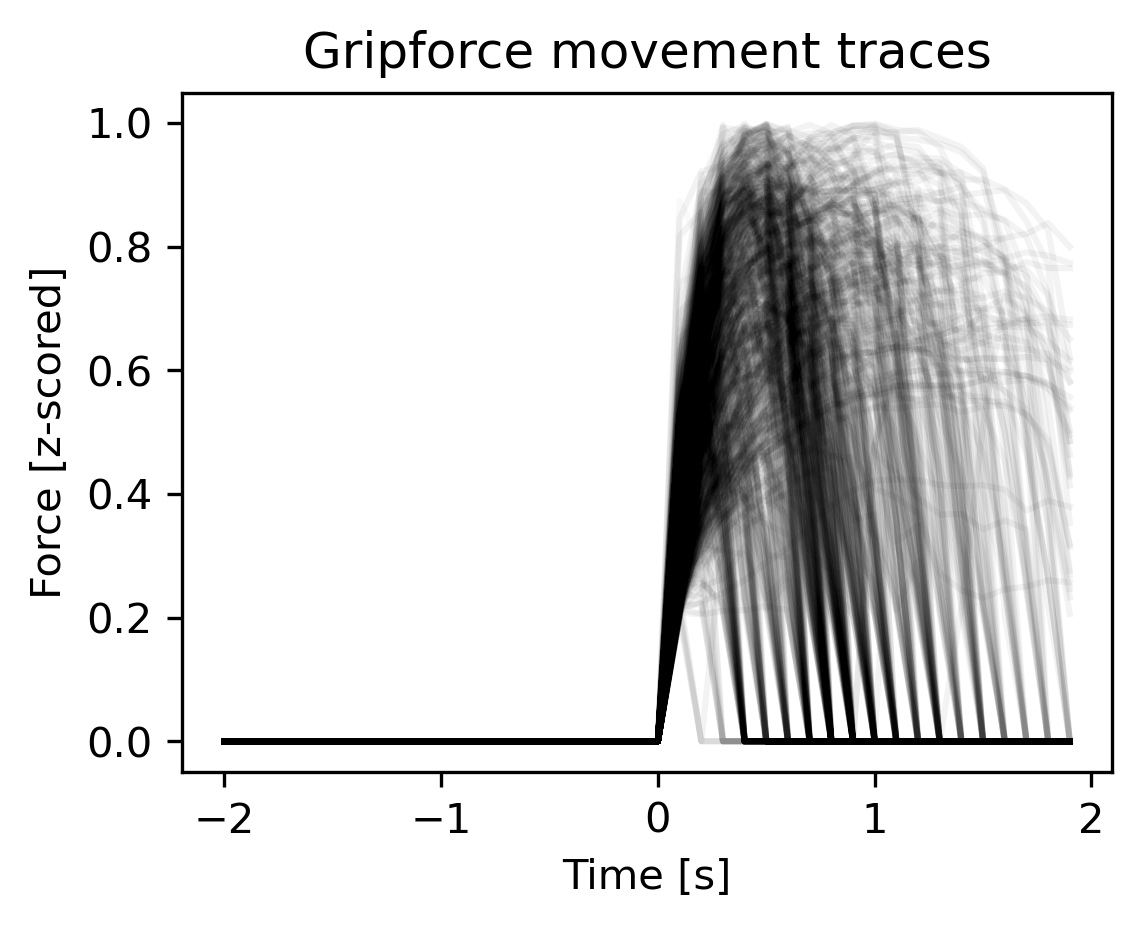

In [33]:
x_ = np.arange(-2, 2., 0.1)
plt.figure(figsize=(4,3), dpi=300)
for i in range(epochs_mov.shape[0]):
    plt.plot(x_, epochs_mov[i, :], color="black", alpha=0.025)
plt.ylabel("Force [z-scored]")
plt.xlabel("Time [s]")
plt.title("Gripforce movement traces")

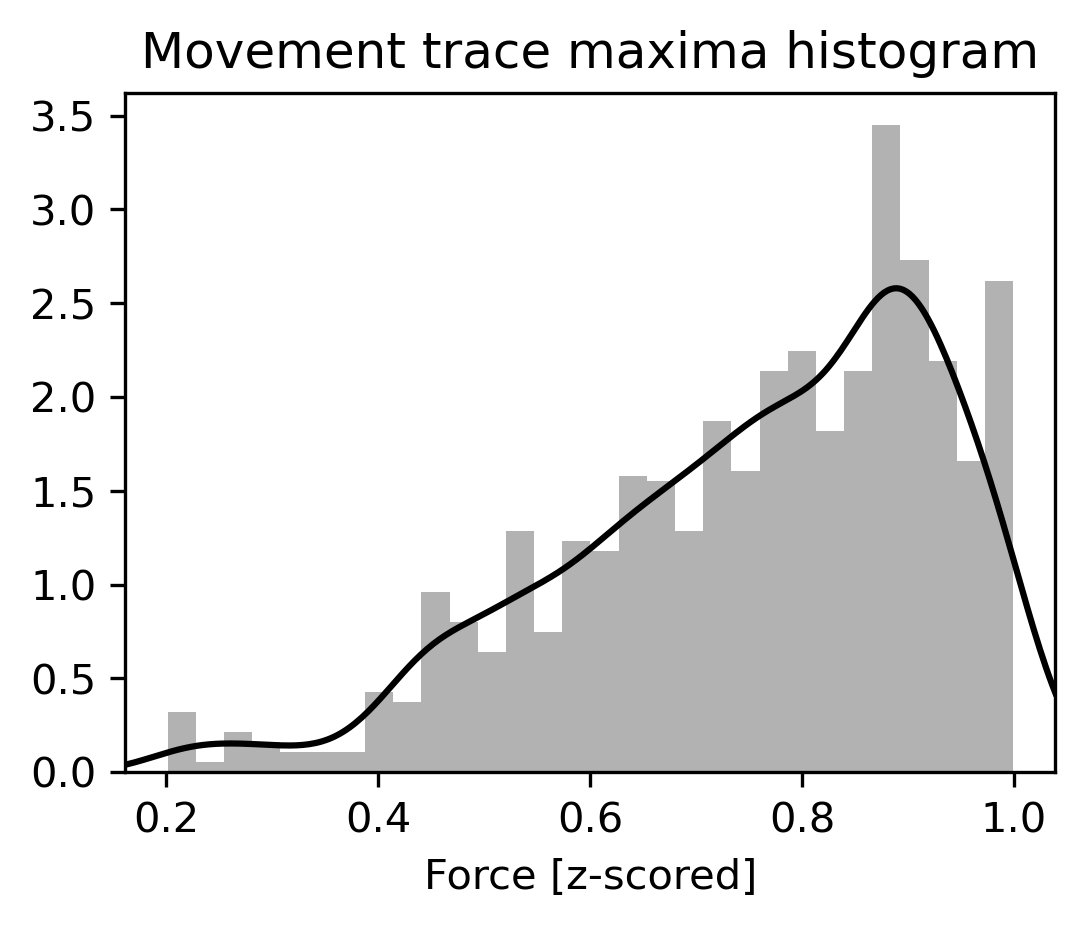

In [34]:
import scipy.stats as st

plt.figure(figsize=(4,3), dpi=300)
plt.hist(np.max(epochs_mov, axis=1), bins=30, density=True, alpha=0.3, color="black")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(np.max(epochs_mov, axis=1))
plt.plot(kde_xs, kde.pdf(kde_xs), color="black")
plt.xlabel("Force [z-scored]")
plt.title("Movement trace maxima histogram")
plt.show()

Text(0.5, 1.0, 'Gripforce velocity traces')

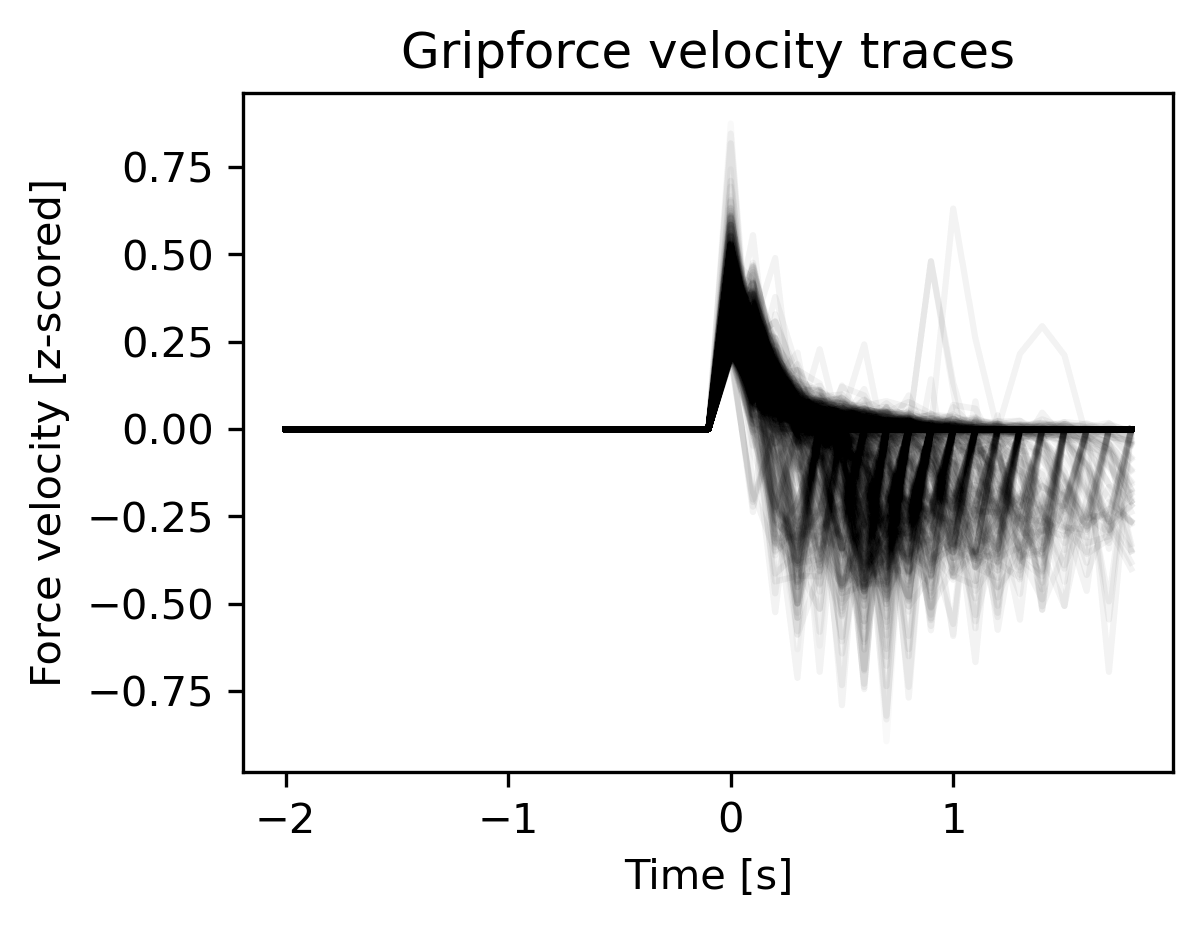

In [37]:
x_ = np.arange(-2, 1.9, 0.1)
plt.figure(figsize=(4,3), dpi=300)
for i in range(np.diff(epochs_mov, axis=1).shape[0]):
    plt.plot(x_, np.diff(epochs_mov, axis=1)[i, :], color="black", alpha=0.025)
plt.ylabel("Force velocity [z-scored]")
plt.xlabel("Time [s]")
plt.title("Gripforce velocity traces")